In [24]:
#In this regression I am focusing on just RF for Ice thickness and Ice Velocity 
#I will look at tuning the hyperparameters to see if I can improve the results of the models 


import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
import math

#+++++++++++++++++++++++++++++++++++++++++++++++++ PREPROCESSING ++++++++++++++++++++++++++++++++++++++++++++++

ice_thickness = pd.read_csv('../data/ice_thickness.csv')

#removing any rows with ice_thickness = 0 (looking only at data points with ice for this analysis)
ice_thickness = ice_thickness[ice_thickness['ice_thickness']!=0]

#method to normalise the data -> scale each column between 0 and 1 
def scale (df):
    """uses the formula scaled val = (val-column minimum)/(column maximum - column minimum)"""
    scaled_df = df.copy()
    # for column in df.columns[:-1]  -> use this line instead for not having a scaled target 
    for column in scaled_df.columns:
        min_value = scaled_df[column].min()
        max_value = scaled_df[column].max()
        scaled_df[column] = (scaled_df[column] - min_value) / (max_value - min_value)
            
    return scaled_df

def unscale_rmse(scaled_rmse, target_name, original_df):
    target_min = original_df[target_name].min()
    target_max = original_df[target_name].max()

    return scaled_rmse * (target_max - target_min)


In [112]:
len(ice_thickness.index)


931

In [180]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import math

def doRandomForestWithTuning(preprocessed_df, seed, n_runs, target_name, original_df):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    importances = []
    best_params = []
    
    X = preprocessed_df.iloc[:, :-1]
    y = preprocessed_df.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    for i in range(n_runs):
        randomState = i * seed

        # Define the model
        rf = RandomForestRegressor(random_state=randomState)

        # Set up the grid of parameters to search
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': [1,2,3], 
            'max_leaf_nodes':[300, 600, 931]
            # Add other parameters here
        }

        # Set up the grid search
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

        # Fit the grid search to the data
        grid_search.fit(X_train, y_train)

        # Store best parameters
        #best_params.append(grid_search.best_params_)
        best_params.append(grid_search.cv_results_['params'][grid_search.best_index_])

    print("Best Parameters per Run:", best_params)

    return best_params, param_grid

In [181]:
seed = 101
scaled_df = scale(ice_thickness)
n_runs = 30
best_params, param_grid = doRandomForestWithTuning(scaled_df, seed, n_runs, "ice_thickness", ice_thickness)


Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Fitting 3 folds for each of 729 candidat

param counts
n_estimators
100    10
200     7
300    13
Name: count, dtype: int64


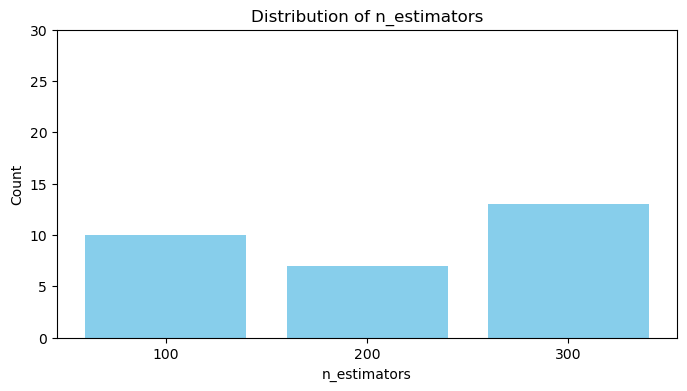

param counts
max_depth
None    14
10      10
20       6
Name: count, dtype: int64


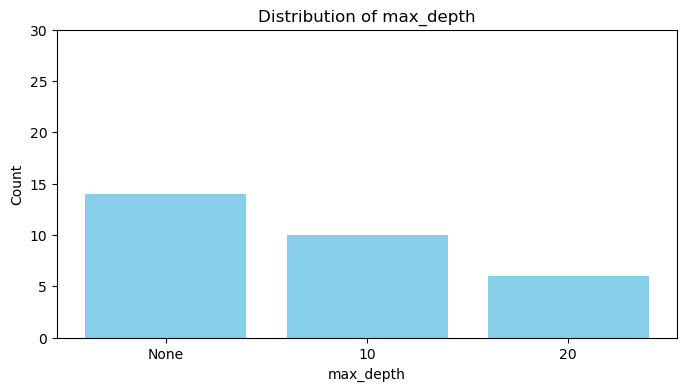

param counts
min_samples_split
2     29
5      1
10     0
Name: count, dtype: int64


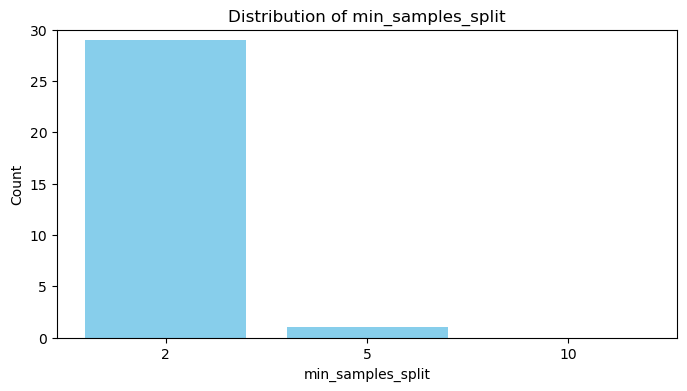

param counts
min_samples_leaf
1    30
2     0
4     0
Name: count, dtype: int64


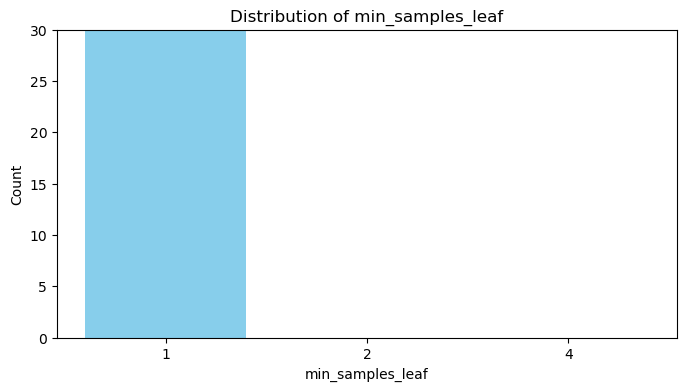

param counts
max_features
1     0
2     8
3    22
Name: count, dtype: int64


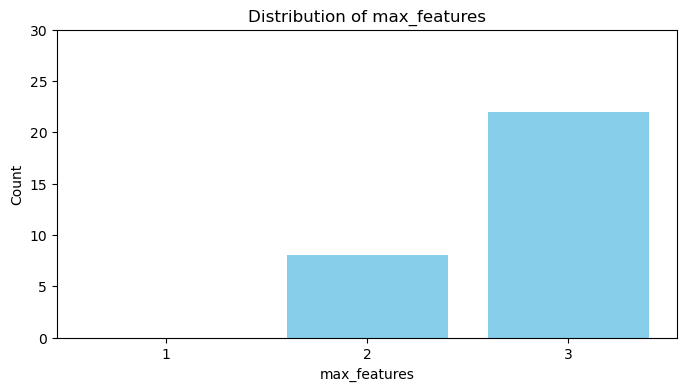

param counts
max_leaf_nodes
300    30
600     0
931     0
Name: count, dtype: int64


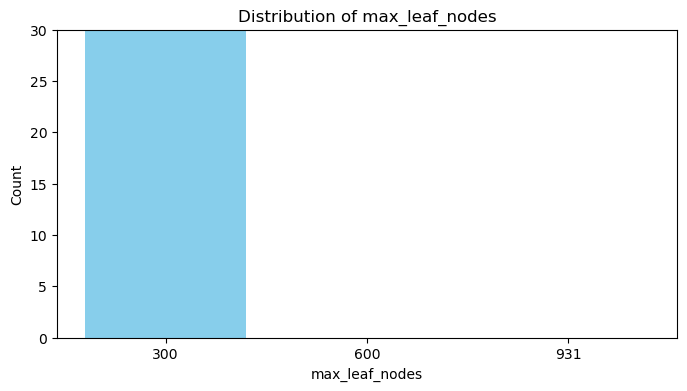

In [182]:
import matplotlib.pyplot as plt

def visualize_parameter_distribution_no_grid(param_dict, param_grid, n_runs):
    # Convert 'None' to string 'None' for 'max_depth'
    for d in param_dict:
        if 'max_depth' in d and d['max_depth'] is None:
            d['max_depth'] = 'None'
    
    # Convert the dictionary to a DataFrame for easier manipulation
    df = pd.DataFrame(param_dict)

    # Loop through each parameter in the grid and create separate bar charts
    for param, values in param_grid.items():
        
        if param == "max_depth":
            values = ['None' if v is None else v for v in values]
            
        
        # Count the occurrences of each parameter value in the dictionary
        param_counts = df[param].value_counts().reindex(values, fill_value=0)
        print("param counts")
        print(param_counts)
        # Plot the bar chart for the parameter
        plt.figure(figsize=(8, 4))
        plt.bar(param_counts.index.astype(str), param_counts.values, color='skyblue')
        plt.title(f'Distribution of {param}')
        plt.xlabel(param)
        plt.ylabel('Count')
        plt.ylim(0, n_runs)  # Set y-axis limit to n_runs
        plt.show()

# Call the function with the 'n_runs' parameter
n_runs=30
visualize_parameter_distribution_no_grid(best_params, param_grid, n_runs)

In [187]:
#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
def doRandomForest(preprocessed_df, seed, n_runs, target_name, original_df):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    importances = []

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

        model = RandomForestRegressor(random_state=randomState, n_estimators = 300, max_depth = 20, 
                                      min_samples_split=2, min_samples_leaf = 1, max_features = 3,
                                     max_leaf_nodes = 300)
        model.fit(X_train, y_train)

        #, max_features = 2
        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        y_train_predicted = model.predict(X_train)
        train_scaled_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_rmse = unscale_rmse(train_scaled_rmse, target_name, original_df)
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
        test_scores.append(model.score(X_test, y_test))
        importances.append(model.feature_importances_)
        y_test_predicted = model.predict(X_test)
        test_scaled_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_rmse = unscale_rmse(test_scaled_rmse, target_name, original_df)
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)
    avg_importances, std_importances = np.mean(importances, axis=0), np.std(importances, axis=0)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")
    print("\n")
    print("Average Importances:", avg_importances)
    print("Importances Std Dev:", std_importances)
    print(f"\n\n Train-Test (Difference): {avg_train_score - avg_test_score :.4f}")


    return avg_importances, std_importances

In [188]:
seed = 101
scaled_df = scale(ice_thickness)
n_runs = 30
importances_IT, std_importances_IT = doRandomForest(scaled_df, seed, n_runs, "ice_thickness", ice_thickness)


Training Average Score: 0.9790, Std Dev: 0.0009
Training Average RMSE: 155.70, Std Dev: 3.21


Test Average Score: 0.8503, Std Dev: 0.0150
Test Average RMSE: 416.48, Std Dev: 19.08


Average Importances: [0.12175142 0.08419578 0.18195718 0.53368505 0.07841057]
Importances Std Dev: [0.00541186 0.00368898 0.01171175 0.01442231 0.00533489]


 Train-Test (Difference): 0.1287


In [159]:
#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
def doRandomForestSetMaxLN(preprocessed_df, seed, n_runs, target_name, original_df, max_leaf_nodes):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    importances = []

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

        model = RandomForestRegressor(random_state=randomState, n_estimators = 300, max_depth = 20, 
                                      min_samples_split=2, min_samples_leaf = 1, max_features = 3,
                                     max_leaf_nodes = max_leaf_nodes)
        model.fit(X_train, y_train)

        #, max_features = 2
        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        y_train_predicted = model.predict(X_train)
        train_scaled_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_rmse = unscale_rmse(train_scaled_rmse, target_name, original_df)
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
        test_scores.append(model.score(X_test, y_test))
        importances.append(model.feature_importances_)
        y_test_predicted = model.predict(X_test)
        test_scaled_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_rmse = unscale_rmse(test_scaled_rmse, target_name, original_df)
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)
    avg_importances, std_importances = np.mean(importances, axis=0), np.std(importances, axis=0)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")
    print("\n")
    print("Average Importances:", avg_importances)
    print("Importances Std Dev:", std_importances)
    print(f"\n\n Train-Test (Difference): {avg_train_score - avg_test_score :.4f}")


    return avg_train_score, avg_test_score

Training Average Score: 0.6792, Std Dev: 0.0083
Training Average RMSE: 608.26, Std Dev: 8.03


Test Average Score: 0.6549, Std Dev: 0.0263
Test Average RMSE: 632.65, Std Dev: 23.78


Average Importances: [0.06790014 0.01139726 0.21644307 0.6809767  0.02328283]
Importances Std Dev: [0.00631168 0.002928   0.01265031 0.01229603 0.00511606]


 Train-Test (Difference): 0.0243
Training Average Score: 0.7963, Std Dev: 0.0042
Training Average RMSE: 484.71, Std Dev: 5.68


Test Average Score: 0.7570, Std Dev: 0.0201
Test Average RMSE: 530.85, Std Dev: 22.42


Average Importances: [0.10175885 0.04104843 0.1907857  0.62427834 0.04212867]
Importances Std Dev: [0.00616656 0.00387996 0.00996345 0.01084353 0.00615342]


 Train-Test (Difference): 0.0393
Training Average Score: 0.8419, Std Dev: 0.0037
Training Average RMSE: 427.00, Std Dev: 5.07


Test Average Score: 0.7936, Std Dev: 0.0176
Test Average RMSE: 489.18, Std Dev: 20.65


Average Importances: [0.11171884 0.05525956 0.18420582 0.60007763 0.0

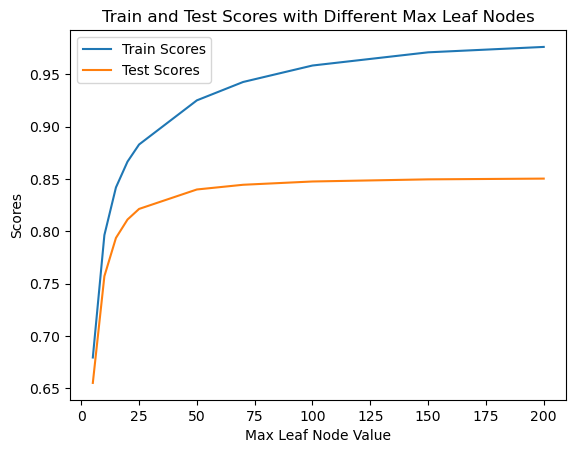

In [160]:
def validate_max_leaf_node(list_of_values):
    test_scores = []
    train_scores = []
    for i in list_of_values:
        train_score, test_score = doRandomForestSetMaxLN(scaled_df, seed, n_runs, "ice_thickness", ice_thickness, i)
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    print("train scores", train_scores)
    print("test scores", test_scores)
    
    # plot the scores
    plt.plot(list_of_values, train_scores, label='Train Scores')
    plt.plot(list_of_values, test_scores, label='Test Scores')
    
    # add labels and title
    plt.xlabel('Max Leaf Node Value')
    plt.ylabel('Scores')
    plt.title('Train and Test Scores with Different Max Leaf Nodes')
    
    # display the legend
    plt.legend()
    
    # show the plot
    plt.show()

validate_max_leaf_node([5, 10, 15, 20, 25,50,70,100,150,200])